# Ride duration time prediction model
In this notebook is going to be build and train a model to predict the ride duration time for the taxis of New York City, all the stages of a ML pipelines are going to be cover here, since the pre-processing of the data, the feature engineering and the modeling and training of the model.

The datasets used in this notebook are the following:
- Train dataset: [fhv_tripdata_2021-01.parquet](../data/fhv_tripdata_2021-01.parquet)
- validation dataset: [fhv_tripdata_2021-02.parquet](../data/fhv_tripdata_2021-02.parquet)

In [1]:
# External imports

# Data processing modules
import pickle
import numpy as np
import pandas as pd

# Modeling modules
from sklearn.metrics import mean_squared_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer

## Exploratory data analysis
Let's make a fast exploratory data analysis to the dataset in order to find the right transformations and operations that have to be done in order to build a model.

In [2]:
# Read the data from the .parquet file 
df = pd.read_parquet("../data/fhv_tripdata_2021-01.parquet")
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [3]:
print("Let's see the data types of the features of the dataset:")
df.dtypes

Let's see the data types of the features of the dataset:


dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [4]:
# Let's print some important metrics 
print(f"The number shape of the dataset is: {df.shape}")
print(f"The number of NaN values in the <PUlocationID> feature is: {df[df.PUlocationID.isna()].shape[0]}")
print(f"The number of NaN values in the <DOlocationID> feature is: {df[df.DOlocationID.isna()].shape[0]}")

The number shape of the dataset is: (1154112, 7)
The number of NaN values in the <PUlocationID> feature is: 958267
The number of NaN values in the <DOlocationID> feature is: 162220


## Data preprocessing 
Let's define a preprocessing pipeline function in order to read the .parquet files and extract the features needed in order to build the model.

In [5]:
# Define a data preprocessing pipeline function 
def data_preprocessing_pipeline(data):
    df = pd.read_parquet(data)
    df.PUlocationID  = df.PUlocationID.apply(lambda x: -1 if (np.isnan(x)) else x)
    df.DOlocationID  = df.DOlocationID.apply(lambda x: -1 if (np.isnan(x)) else x)
    
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)

    return df[["PUlocationID","DOlocationID","duration"]]

In [6]:
# Let's preprocess the train and validation dataset
df_train = data_preprocessing_pipeline("../data/fhv_tripdata_2021-01.parquet")
df_val = data_preprocessing_pipeline("../data/fhv_tripdata_2021-02.parquet")

## Feature engineering
Let's do the feature engineering with the datasets, do the one-hot encoding to the categorical variables that are going to be use to build the model.

In [7]:
# Define the DictVectorizer object to do the one-hot encoding
dv = DictVectorizer()

train_dicts = df_train[["PUlocationID","DOlocationID"]].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[["PUlocationID","DOlocationID"]].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
# Define the target variable 
y_train = df_train.duration.values
y_val = df_val.duration.values

## Modeling
Let's build and train a simple linear regression model.

In [9]:
# Build and train the linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f"The R^2 is: {lr.score(X_train, y_train)}")

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

print(f"Train - RMSE: {mean_squared_error(y_train, y_pred_train, squared=False)}")
print(f"Val - RMSE: {mean_squared_error(y_val, y_pred_val, squared=False)}")

The R^2 is: 0.16927348635061046
Train - RMSE: 10.528519107212144
Val - RMSE: 11.014283226749118


In [60]:
# Save the model
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

## Model Validation
Let's plot the residual plot of the model in order to see their performance.

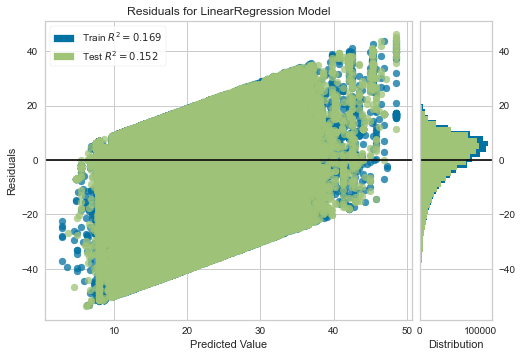

In [12]:
# Build and train the model and make the residual plot visualization using yellowbrick module
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
visualizer.show();  